In [14]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("./utils")

import numpy as np
import pandas as pd
import joblib
import pickle
import seaborn as sns
from finta import TA
from utils.get_targets import get_first_threshold_bump, get_close_price_target
from stockstats import StockDataFrame
from matplotlib import pyplot as plt
import optuna
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
DATA_PATH = "./data/prices/AAPL_15minute_train.csv"
TEST_PATH = "./data/prices/AAPL_15minute_test.csv"
MEAN_TARGET_ENCODING_PATH = "./strategies/bitcoin_lgb_mean_target_encoding/mean_target_encoding"
MODEL_PATH = "./aapl_trader.txt"

TEST_RATIO = 0.2
TIME_LAG = 2

In [16]:
def prepare_dataset(path: str) -> pd.DataFrame:
    data = pd.read_csv(DATA_PATH, index_col=0)
    data = data.join(pd.Series(get_close_price_target(data, TIME_LAG), name="target"))
    data.dropna(inplace=True)
    
    return data

In [17]:
data = prepare_dataset(DATA_PATH)
data

,volume,open,close,high,low,date,ticker,target
0,13828.0,72.0625,72.000,72.0625,71.7875,2020-05-04 07:51:00,AAPL,-0.0800
1,6856.0,72.0000,71.975,72.0000,71.9050,2020-05-04 08:06:00,AAPL,0.0250
2,7012.0,72.0100,71.920,72.0150,71.9200,2020-05-04 08:21:00,AAPL,-0.0450
3,1064.0,71.9725,72.000,72.0000,71.9725,2020-05-04 08:36:00,AAPL,-0.0900
4,20052.0,72.0625,71.875,72.0625,71.8750,2020-05-04 08:51:00,AAPL,-0.1075
...,...,...,...,...,...,...,...,...
25465,63485.0,162.4500,162.550,162.5900,162.0200,2021-12-06 12:15:00,AAPL,0.9600
25466,185098.0,162.5500,163.400,163.4500,162.4000,2021-12-06 12:30:00,AAPL,0.2200
25467,112565.0,163.3800,163.510,163.6500,163.2800,2021-12-06 12:45:00,AAPL,0.3900
25468,400181.0,162.3102,163.620,163.7900,161.4360,2021-12-06 13:00:00,AAPL,0.1800


In [83]:
df = pd.DataFrame([])
s = pd.Series({"a": 2, "b": 3})
df = df.append(s, ignore_index=True)
df

,a,b
0,2.0,3.0


Выведем, в какой период собрана выборка.

In [18]:
dates = data.date.apply(lambda date: pd.Timestamp(date))
print(f"С {dates.min()} по {dates.max()}")

С 2020-05-04 07:51:00 по 2021-12-06 13:15:00


In [19]:
train_df, test_df = train_test_split(data, test_size=TEST_RATIO, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
display(train_df)
display(test_df)

,volume,open,close,high,low,date,ticker,target
0,13828.0,72.0625,72.0000,72.0625,71.7875,2020-05-04 07:51:00,AAPL,-0.0800
1,6856.0,72.0000,71.9750,72.0000,71.9050,2020-05-04 08:06:00,AAPL,0.0250
2,7012.0,72.0100,71.9200,72.0150,71.9200,2020-05-04 08:21:00,AAPL,-0.0450
3,1064.0,71.9725,72.0000,72.0000,71.9725,2020-05-04 08:36:00,AAPL,-0.0900
4,20052.0,72.0625,71.8750,72.0625,71.8750,2020-05-04 08:51:00,AAPL,-0.1075
...,...,...,...,...,...,...,...,...
20371,2236328.0,146.3050,146.4750,146.5900,146.2194,2021-08-11 17:00:00,AAPL,-0.5854
20372,990374.0,146.4800,146.3482,146.4900,146.2400,2021-08-11 17:15:00,AAPL,-0.2982
20373,1217531.0,146.3450,145.8896,146.3700,145.8700,2021-08-11 17:30:00,AAPL,0.1204
20374,1112323.0,145.8900,146.0500,146.0850,145.8200,2021-08-11 17:45:00,AAPL,-0.1150


,volume,open,close,high,low,date,ticker,target
0,921974.0,146.0200,145.935,146.02,145.800,2021-08-11 18:15:00,AAPL,0.0250
1,831543.0,145.9350,146.020,146.06,145.870,2021-08-11 18:30:00,AAPL,-0.0600
2,846979.0,146.0200,145.960,146.04,145.890,2021-08-11 18:45:00,AAPL,-0.0350
3,956352.0,145.9700,145.960,146.01,145.885,2021-08-11 19:00:00,AAPL,-0.1357
4,1080808.0,145.9600,145.925,146.09,145.890,2021-08-11 19:15:00,AAPL,-0.0150
...,...,...,...,...,...,...,...,...
5089,63485.0,162.4500,162.550,162.59,162.020,2021-12-06 12:15:00,AAPL,0.9600
5090,185098.0,162.5500,163.400,163.45,162.400,2021-12-06 12:30:00,AAPL,0.2200
5091,112565.0,163.3800,163.510,163.65,163.280,2021-12-06 12:45:00,AAPL,0.3900
5092,400181.0,162.3102,163.620,163.79,161.436,2021-12-06 13:00:00,AAPL,0.1800


In [20]:
def estimate_mean_target_regularization(category, global_mean: float, category_means: pd.Series,
                                        category_counts: pd.Series, alpha: float) -> float:
    try:
        return (category_counts[category] * category_means[category] + global_mean * alpha) / (category_counts[category] * alpha)
    except:
        return global_mean

In [21]:
def mean_target_regularization(dataset: pd.DataFrame, column: str, target_name: str, train: bool = True) -> pd.Series:
    encoding_file_path = MEAN_TARGET_ENCODING_PATH + "_" + column + ".pickle"
    if train:
        encoding = {
            "global_mean": dataset[target_name].mean(),
            "counts": dataset.groupby(dataset[column]).count()[target_name],
            "category_means": dataset.groupby(dataset[column]).mean()[target_name]
        }
        with open(encoding_file_path, "wb") as output_file:
            pickle.dump(encoding, output_file)
    else:
        with open(encoding_file_path, "rb") as input_file:
            encoding = pickle.load(input_file)
    
    global_mean = encoding["global_mean"]
    counts = encoding["counts"]
    category_means = encoding["category_means"]
    
    target_mean = dataset[column].apply(
        lambda category: estimate_mean_target_regularization(
            category,
            global_mean=global_mean,
            category_means=category_means,
            category_counts=counts,
            alpha=10
        )
    )
    
    return target_mean

In [22]:
def get_features(dataset: pd.DataFrame, train: bool = True) -> pd.DataFrame:
    
    initial_features = ["open", "close", "low", "high", "volume"]
    result_dataset = dataset.copy()
    
    # FINTA INDICATORS: MFV, OBV, VFI, VPT, PSAR, SAR
    finta_indicators = ['ADL', 'ADX', 'AO', 'ATR', 'BASP', 'BASPN', 'BBANDS', 'BBWIDTH',
                        'BOP', 'CCI', 'CFI', 'CHAIKIN', 'CHANDELIER', 'CMO', 'COPP', 'DEMA', 'DMI', 'DO',
                        'DYMI', 'EBBP', 'EFI', 'EMA', 'EMV', 'ER', 'EVSTC', 'EVWMA', 'FISH', 'FRAMA', 'FVE',
                        'HMA', 'ICHIMOKU', 'KAMA', 'KC', 'KST', 'MACD', 'MFI', 'MI', 'MOBO',
                        'MOM', 'MSD', 'PIVOT', 'PPO', 'PZO', 'QSTICK', 'ROC', 'RSI',
                        'SMA', 'SMM', 'SMMA', 'SQZMI', 'SSMA', 'STC', 'STOCH', 'STOCHD', 'STOCHRSI',
                        'TEMA', 'TP', 'TR', 'TRIMA', 'TRIX', 'TSI', 'UO', 'VAMA', 'VBM',
                        'VORTEX','VWAP', 'VZO', 'WILLIAMS', 'WMA', 'WOBV', 'WTO', 'ZLEMA']
    
    for indicator in tqdm(finta_indicators):
        try:
            indicator_method = getattr(TA, indicator)
            indicator_result = indicator_method(result_dataset[initial_features])
            result_dataset = pd.concat([result_dataset, indicator_result], axis=1)
        except Exception as e:
            print("Error while calculating", indicator)
            
        assert len(result_dataset) == len(dataset)
    
    return result_dataset

In [23]:
train_preprocessed_df = get_features(train_df, train=True).reset_index(drop=True)
test_preprocessed_df = get_features(test_df, train=False).reset_index(drop=True)
test_preprocessed_df["target"] = test_df["target"]

display(train_preprocessed_df)
display(test_preprocessed_df)

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:14<00:00,  4.90it/s]


,volume,open,close,high,low,date,ticker,target,MFV,14 period ADX.,AO,14 period ATR,Buy.,Sell.,Buy.,Sell.,BB_UPPER,BB_MIDDLE,BB_LOWER,20 period BBWITH,Balance Of Power,20 period CCI,CFI,MFV,Short.,Long.,CMO,Coppock Curve,9 period DEMA,DI+,DI-,LOWER,MIDDLE,UPPER,0,Bull.,Bear.,13 period Force Index,9 period EMA,14 period EMV.,10 period ER,10 period EVSTC,20 period EVWMA.,10 period FISH.,16 period FRAMA.,0,16 period HMA.,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,20 period KAMA.,KC_UPPER,KC_LOWER,KST,signal,MACD,SIGNAL,14 period MFI,Mass Index,BB_UPPER,BB_MIDDLE,BB_LOWER,MOM,MSD,pivot,s1,s2,s3,s4,r1,r2,r3,r4,PPO,SIGNAL,HISTO,14 period PZO,14 period QSTICK.,ROC,14 period RSI,41 period SMA,9 period SMM,SMMA,20 period SQZMI,9 period SSMA,10 period STC,14 period STOCH %K,3 period STOCH %D.,14 period stochastic RSI.,9 period TEMA,TP,TR,18 period TRIMA,20 period TRIX,TSI,signal,0,8 period VAMA,VBM,VIm,VIp,VWAP.,VZO,14 Williams %R,9 period WMA.,WOBV,WT1.,WT2.,26 period ZLEMA
0,13828.0,72.0625,72.0000,72.0625,71.7875,2020-05-04 07:51:00,AAPL,-0.0800,7.542545e+03,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,-0.227273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.062500,-0.212500,NaN,72.000000,NaN,NaN,NaN,0.000000,0.000000,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,72.4373,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,72.000000,False,72.000000,NaN,NaN,NaN,NaN,72.000000,71.950000,0.2750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,6856.0,72.0000,71.9750,72.0000,71.9050,2020-05-04 08:06:00,AAPL,0.0250,1.079012e+04,NaN,NaN,NaN,0.335554,0.386173,0.651166,0.677741,NaN,NaN,NaN,NaN,-0.263158,66.666667,NaN,NaN,NaN,NaN,-100.000000,NaN,71.979938,NaN,NaN,NaN,NaN,NaN,NaN,0.013462,-0.081538,-171.400000,71.986111,NaN,NaN,NaN,0.000000,0.000000,71.975000,NaN,NaN,NaN,NaN,NaN,NaN,72.5036,NaN,NaN,NaN,NaN,NaN,-0.000561,-0.000312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.950000,71.837500,71.675000,71.562500,71.4500,72.112500,72.225000,72.387500,72.5500,-0.000779,-0.000433,-0.000346,-53.562791,NaN,NaN,0.000000,NaN,NaN,71.987349,False,71.986765,NaN,NaN,NaN,NaN,71.977195,71.960000,0.0950,NaN,-0.005025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.953315,-36.390143,NaN,NaN,-1.714000e+02,121.212121,NaN,NaN
2,7012.0,72.0100,71.9200,72.0150,71.9200,2020-05-04 08:21:00,AAPL,-0.0450,3.778124e+03,NaN,NaN,NaN,0.000000,1.189878,0.412062,0.865794,NaN,NaN,NaN,NaN,-0.947368,-36.363636,NaN,NaN,NaN,NaN,-100.000000,NaN,71.939383,NaN,NaN,NaN,NaN,NaN,NaN,0.054134,-0.040866,-286.770769,71.959016,NaN,NaN,NaN,0.000000,0.000000,71.920000,NaN,NaN,NaN,NaN,NaN,NaN,72.7200,NaN,NaN,NaN,NaN,NaN,-0.002420,-0.001176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.960000,71.920000,71.865000,71.825000,71.7850,72.015000,72.055000,72.110000,72.1650,-0.003363,-0.001634,-0.001729,-71.291815,NaN,NaN,0.000000,NaN,NaN,71.964356,False,71.961843,NaN,NaN,NaN,NaN,71.929820,71.951667,0.0950,NaN,-0.007436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.952897,-55.500165,NaN,NaN,-5.570600e+02,24.387567,NaN,NaN
3,1064.0,71.9725,72.0000,72.0000,71.9725,2020-05-04 08:36:00,AAPL,-0.0900,4.842124e+03,NaN,NaN,NaN,0.057147,0.000000,0.309603,0.615853,NaN,NaN,NaN,NaN,1.000000,133.333333,NaN,NaN,NaN,NaN,6.844741,NaN,71.969098,NaN,NaN,NaN,NaN,NaN,NaN,0.026986,-0.000514,-143.285354,71.972900,NaN,NaN,NaN,0.000000,0.000000,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,72.6400,NaN,NaN,NaN,NaN,NaN,-0.000318,-0.000885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.951667,71.888333,71.856667,71.793333,71.7300,71.983333,72.046667,72.078333,72.1100,-0.000442,-0.001230,0.000788,-18.869191,NaN,NaN,52.415176,NaN,NaN,71.973592,False,71.973128,NaN,NaN,NaN,NaN,71.973242,71.990833,0.0800,NaN,-0.004696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.954301,-47.729611,NaN,NaN,-4.719400e+02,77.235189,NaN,NaN
4,20052.0,72.0625,71.8750,72.0625,71.8750,2020-05-04 08:51:00,AAPL,-0.1075,-1.520988e+04,NaN,NaN,NaN,0.000000,5.006174,0.234713,1.677834,NaN,NaN,NaN,NaN,-1.000000,-

,volume,open,close,high,low,date,ticker,target,MFV,14 period ADX.,AO,14 period ATR,Buy.,Sell.,Buy.,Sell.,BB_UPPER,BB_MIDDLE,BB_LOWER,20 period BBWITH,Balance Of Power,20 period CCI,CFI,MFV,Short.,Long.,CMO,Coppock Curve,9 period DEMA,DI+,DI-,LOWER,MIDDLE,UPPER,0,Bull.,Bear.,13 period Force Index,9 period EMA,14 period EMV.,10 period ER,10 period EVSTC,20 period EVWMA.,10 period FISH.,16 period FRAMA.,0,16 period HMA.,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,20 period KAMA.,KC_UPPER,KC_LOWER,KST,signal,MACD,SIGNAL,14 period MFI,Mass Index,BB_UPPER,BB_MIDDLE,BB_LOWER,MOM,MSD,pivot,s1,s2,s3,s4,r1,r2,r3,r4,PPO,SIGNAL,HISTO,14 period PZO,14 period QSTICK.,ROC,14 period RSI,41 period SMA,9 period SMM,SMMA,20 period SQZMI,9 period SSMA,10 period STC,14 period STOCH %K,3 period STOCH %D.,14 period stochastic RSI.,9 period TEMA,TP,TR,18 period TRIMA,20 period TRIX,TSI,signal,0,8 period VAMA,VBM,VIm,VIp,VWAP.,VZO,14 Williams %R,9 period WMA.,WOBV,WT1.,WT2.,26 period ZLEMA
0,921974.0,146.0200,145.935,146.02,145.800,2021-08-11 18:15:00,AAPL,0.0250,2.095395e+05,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,-0.386364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.935000,NaN,NaN,NaN,NaN,NaN,NaN,0.085000,-0.135000,NaN,145.935000,NaN,NaN,NaN,0.000000,0.000000,145.935000,NaN,NaN,NaN,NaN,NaN,NaN,145.76,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,145.935000,False,145.935000,NaN,NaN,NaN,NaN,145.935000,145.918333,0.220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.918333,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,831543.0,145.9350,146.020,146.06,145.870,2021-08-11 18:30:00,AAPL,-0.0600,6.909592e+05,NaN,NaN,NaN,0.998321,0.613298,0.999119,0.796981,NaN,NaN,NaN,NaN,0.447368,66.666667,NaN,NaN,NaN,NaN,100.000000,NaN,146.003210,NaN,NaN,NaN,NaN,NaN,NaN,0.079231,-0.110769,70681.155000,145.982222,NaN,NaN,NaN,0.000000,0.000000,146.020000,NaN,NaN,NaN,NaN,NaN,NaN,145.74,NaN,NaN,NaN,NaN,NaN,0.001907,0.001059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.918333,145.816667,145.698333,145.596667,145.495,146.036667,146.138333,146.256667,146.375,0.001306,0.000726,0.000581,53.585911,NaN,NaN,100.000000,NaN,NaN,145.978012,False,145.980000,NaN,NaN,NaN,NaN,146.012538,145.983333,0.190,NaN,0.008428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.949157,50.996539,NaN,NaN,7.068116e+04,121.212121,NaN,NaN
2,846979.0,146.0200,145.960,146.04,145.890,2021-08-11 18:45:00,AAPL,-0.0350,6.344939e+05,NaN,NaN,NaN,0.584238,1.146751,0.846777,0.925415,NaN,NaN,NaN,NaN,-0.400000,22.727273,NaN,NaN,NaN,NaN,12.087912,NaN,145.980126,NaN,NaN,NaN,NaN,NaN,NaN,0.067244,-0.082756,5258.134615,145.973115,NaN,NaN,NaN,0.000000,0.000000,145.960000,NaN,NaN,NaN,NaN,NaN,NaN,145.77,NaN,NaN,NaN,NaN,NaN,0.000569,0.000859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.983333,145.906667,145.793333,145.716667,145.640,146.096667,146.173333,146.286667,146.400,0.000390,0.000588,-0.000198,-5.079328,NaN,NaN,56.812339,NaN,NaN,145.971863,False,145.972535,NaN,NaN,NaN,NaN,145.977383,145.963333,0.150,NaN,0.004092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.953774,-5.588485,NaN,NaN,1.986242e+04,74.029099,NaN,NaN
3,956352.0,145.9700,145.960,146.01,145.885,2021-08-11 19:00:00,AAPL,-0.1357,8.257643e+05,NaN,NaN,NaN,0.761196,0.848115,0.822071,0.903099,NaN,NaN,NaN,NaN,-0.080000,-8.695652,NaN,NaN,NaN,NaN,12.087912,NaN,145.970371,NaN,NaN,NaN,NaN,NaN,NaN,0.041204,-0.083796,3229.405512,145.968672,NaN,NaN,NaN,0.000000,0.000000,145.960000,NaN,NaN,NaN,NaN,NaN,NaN,145.80,NaN,NaN,NaN,NaN,NaN,-0.000053,0.000550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.963333,145.886667,145.813333,145.736667,145.660,146.036667,146.113333,146.186667,146.260,-0.000036,0.000377,-0.000413,-3.525512,NaN,NaN,56.812339,NaN,NaN,145.968789,False,145.968828,NaN,NaN,NaN,NaN,145.965043,145.951667,0.125,NaN,0.002337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.953208,-3.755113,NaN,NaN,1.986242e+04,36.183645,NaN,NaN
4,1080808.0,145.9600,145.925,146.09,145.890,2021-08-11 19:15:00,AAPL,-0.0150,1.232391e+05,NaN,NaN,NaN,0.449710,2.230936,0.732000,1.224

Посмотрим, у каких признаков много пропущенных значений.

In [24]:
print(train_preprocessed_df.isna().sum().sort_values().to_markdown())

|                           |     0 |
|:--------------------------|------:|
| volume                    |     0 |
| SIGNAL                    |     0 |
| MACD                      |     0 |
| 20 period SQZMI           |     0 |
| SMMA                      |     0 |
| 9 period DEMA             |     0 |
| 14 period PZO             |     0 |
| HISTO                     |     0 |
| Bull.                     |     0 |
| Bear.                     |     0 |
| 9 period EMA              |     0 |
| SIGNAL                    |     0 |
| PPO                       |     0 |
| 20 period EVWMA.          |     0 |
| 10 period FISH.           |     0 |
| 16 period FRAMA.          |     0 |
| 9 period TEMA             |     0 |
| TP                        |     0 |
| 9 period SSMA             |     0 |
| VZO                       |     0 |
| date                      |     0 |
| TR                        |     0 |
| low                       |     0 |
| high                      |     0 |
| close     

Выбросим ненужные колонки и колонки с большим количеством пропущенных значений.

In [25]:
a_lot_of_nans = train_preprocessed_df.isna().sum() > 100
a_lot_of_nans = a_lot_of_nans[a_lot_of_nans].index.tolist()

drop_columns = a_lot_of_nans + ["date", "ticker"]
print(drop_columns)

train_preprocessed_df.drop(drop_columns, axis=1, inplace=True)
train_preprocessed_df.dropna(inplace=True)

test_preprocessed_df.drop(drop_columns, axis=1, inplace=True)
test_preprocessed_df.dropna(inplace=True)

train_preprocessed_df

['MFV', 'Balance Of Power', '14 period QSTICK.', 'date', 'ticker']


,volume,open,close,high,low,target,14 period ADX.,AO,14 period ATR,Buy.,Sell.,Buy.,Sell.,BB_UPPER,BB_MIDDLE,BB_LOWER,20 period BBWITH,20 period CCI,CFI,Short.,Long.,CMO,Coppock Curve,9 period DEMA,DI+,DI-,LOWER,MIDDLE,UPPER,0,Bull.,Bear.,13 period Force Index,9 period EMA,14 period EMV.,10 period ER,10 period EVSTC,20 period EVWMA.,10 period FISH.,16 period FRAMA.,0,16 period HMA.,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,20 period KAMA.,KC_UPPER,KC_LOWER,KST,signal,MACD,SIGNAL,14 period MFI,Mass Index,BB_UPPER,BB_MIDDLE,BB_LOWER,MOM,MSD,pivot,s1,s2,s3,s4,r1,r2,r3,r4,PPO,SIGNAL,HISTO,14 period PZO,ROC,14 period RSI,41 period SMA,9 period SMM,SMMA,20 period SQZMI,9 period SSMA,10 period STC,14 period STOCH %K,3 period STOCH %D.,14 period stochastic RSI.,9 period TEMA,TP,TR,18 period TRIMA,20 period TRIX,TSI,signal,0,8 period VAMA,VBM,VIm,VIp,VWAP.,VZO,14 Williams %R,9 period WMA.,WOBV,WT1.,WT2.,26 period ZLEMA
77,76976.0,73.8075,73.7750,73.8500,73.7500,0.1000,28.097216,0.333399,0.162321,0.033627,0.118129,0.121576,0.108959,74.028444,73.592625,73.156806,0.011844,6.477054e+01,5.769542e+06,73.572045,73.655455,25.170750,0.795942,73.787691,39.434915,25.068024,73.6850,73.86250,74.04,60.780873,0.184582,0.084582,3227.447522,73.708011,0.393576,0.164474,9.582610e+01,72.654616,0.537713,73.780632,-3.315317,73.749610,73.57500,73.60750,72.846250,72.50465,74.9075,73.615890,73.812590,73.350590,8.271507,8.561063,0.168700,0.179572,71.629669,21.368948,73.769304,73.66925,73.569196,-0.1250,0.221013,73.744167,73.738333,73.726667,73.720833,73.715,73.755833,73.761667,73.773333,73.785,0.229500,0.244620,-0.015120,35.923358,-0.304054,62.782539,73.282410,73.745,73.108400,False,73.618419,58.888003,64.189189,61.711712,0.681015,73.776228,73.791667,0.1000,73.411443,0.036799,25.382543,27.967937,67.402290,73.726727,-634.819079,0.962596,0.911991,72.619156,35.646508,-35.810811,73.726722,5.763210e+06,46.698204,46.553375,73.822059
78,50660.0,73.7750,73.8250,73.9025,73.7375,0.1500,27.876922,0.320479,0.171250,0.080161,0.082945,0.117630,0.106481,74.050101,73.615125,73.180149,0.011818,6.796251e+01,5.771029e+06,73.641705,73.648295,30.023372,0.734313,73.813871,38.803170,23.263897,73.6850,73.86250,74.04,61.562075,0.214284,0.049284,3128.240138,73.731409,0.392491,0.348624,8.054109e+01,72.801559,0.972717,73.784081,-3.201771,73.782382,73.70125,73.60875,72.918750,72.50465,74.9732,73.631640,73.815780,73.393780,8.348427,8.526152,0.167992,0.177256,74.782525,21.649581,73.795000,73.68825,73.581500,0.1900,0.218361,73.791667,73.733333,73.691667,73.633333,73.575,73.833333,73.891667,73.933333,73.975,0.228463,0.241388,-0.012926,44.484201,0.060992,64.386934,73.323202,73.750,73.128449,False,73.641374,56.636792,70.945946,65.315315,0.677754,73.806926,73.821667,0.1650,73.436458,0.036524,25.822822,27.661144,64.643900,73.764265,-612.495208,0.954119,0.886340,72.619628,40.263526,-29.054054,73.757111,5.765743e+06,48.072783,46.697471,73.825631
79,44524.0,73.8250,73.8750,73.8750,73.7850,0.0876,27.672592,0.303854,0.134821,0.074939,0.000000,0.113563,0.096336,74.067892,73.643500,73.219108,0.011526,6.998150e+01,5.772650e+06,73.695455,73.644545,34.726629,0.629349,73.849071,36.012043,21.590516,73.6850,73.86250,74.04,49.891121,0.160100,0.070100,2999.376599,73.760127,-0.486111,0.825137,5.414496e+01,72.918588,1.432157,73.789312,-3.189152,73.819421,73.70125,73.61125,72.929375,72.50465,74.9650,73.708332,73.792524,73.468524,8.500468,8.521437,0.169503,0.175706,77.854563,21.999746,73.827365,73.72600,73.624635,0.3775,0.219435,73.821667,73.740833,73.656667,73.575833,73.495,73.905833,73.986667,74.070833,74.155,0.230437,0.239198,-0.008761,51.903638,-0.033829,65.966910,73.358629,73.775,73.149250,False,73.667335,62.739250,77.702703,70.945946,0.665545,73.848701,73.845000,0.0900,73.461505,0.036284,26.625923,27.513112,59.885087,73.786855,-608.243671,1.017219,0.866225,72.620051,44.314926,-22.297297,73.790222,5.767969e+06,49.416496,47.474124,73.827445
80,84840.0,73.8625,73.9750,73.9750,73.8525,0.0625,28.007228,0.320265,0.124

Применим неравенство Чебышёва, чтобы отсеять 5 процентов выбросов из выборки.
$$
P(\vert EX - X \vert \ge a) \le \dfrac{\sigma^2}{a^2},
$$
где $a$ такое, что $\dfrac{\sigma^2}{a^2} = 0.05$.

In [28]:
std = train_preprocessed_df["target"].std()
threshold = np.sqrt(std ** 2 / 0.05)
print("Threshold:", threshold)

Threshold: 1.9428875164348958


In [29]:
print(f"Всего {(train_preprocessed_df['target'] >= threshold).sum()} выбросов")

Всего 66 выбросов


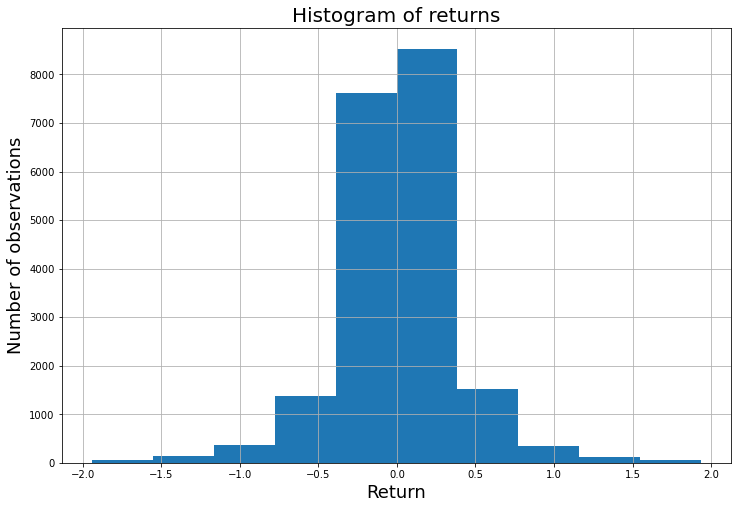

In [30]:
plt.figure(figsize=(12, 8))
target_bounded = train_preprocessed_df.loc[np.abs(train_preprocessed_df["target"]) < threshold, "target"]
plt.hist(target_bounded)
plt.grid()

plt.title("Histogram of returns", fontsize=20)
plt.xlabel("Return", fontsize=18)
plt.ylabel("Number of observations", fontsize=18)
plt.show()

Посмотрим на Mutual Information (MI) признаков.

In [31]:
from sklearn.feature_selection import mutual_info_regression

def compute_mi_scores(X, y):
    scores = mutual_info_regression(X, y)
    result = pd.Series(scores, name="MI scores", index=X.columns).sort_values(ascending=False)
    
    return result

In [34]:
mi_scores = compute_mi_scores(train_preprocessed_df.drop(["target"], axis=1), train_preprocessed_df["target"])
print(mi_scores.to_markdown())

|                           |   MI scores |
|:--------------------------|------------:|
| TR                        | 0.156504    |
| volume                    | 0.142653    |
| Sell.                     | 0.127451    |
| Buy.                      | 0.121249    |
| WOBV                      | 0.115076    |
| CFI                       | 0.100805    |
| VWAP.                     | 0.0953147   |
| Buy.                      | 0.0853125   |
| 20 period EVWMA.          | 0.0776043   |
| 14 period ATR             | 0.0724144   |
| SMMA                      | 0.0709095   |
| UPPER                     | 0.0682259   |
| SENKOU                    | 0.0667431   |
| KIJUN                     | 0.066507    |
| BB_MIDDLE                 | 0.0661542   |
| Sell.                     | 0.0660454   |
| 16 period FRAMA.          | 0.0646702   |
| BB_LOWER                  | 0.0635718   |
| 18 period TRIMA           | 0.0625012   |
| 9 period TEMA             | 0.0623364   |
| 9 period SSMA             | 0.

Посмотрим на корреляции с таргетом.

In [33]:
target_corr = train_preprocessed_df.corr()["target"]
print(target_corr.sort_values(key=lambda key: np.abs(key), ascending=False).to_markdown())

|                           |       target |
|:--------------------------|-------------:|
| target                    |  1           |
| MOM                       | -0.0379899   |
| Bear.                     | -0.0304467   |
| HISTO                     | -0.0304438   |
| Bull.                     | -0.0297523   |
| 13 period Force Index     | -0.0285959   |
| ROC                       | -0.0240792   |
| 0                         | -0.0215234   |
| r4                        | -0.0205291   |
| r3                        | -0.0202514   |
| close                     | -0.0200905   |
| r2                        | -0.0199702   |
| TP                        | -0.0199311   |
| low                       | -0.0198991   |
| r1                        | -0.0198272   |
| 9 period TEMA             | -0.0198244   |
| high                      | -0.0198001   |
| open                      | -0.0196312   |
| pivot                     | -0.0195393   |
| 9 period DEMA             | -0.0195226   |
| 16 perio

Посмотрим на график цен за тренировочный период

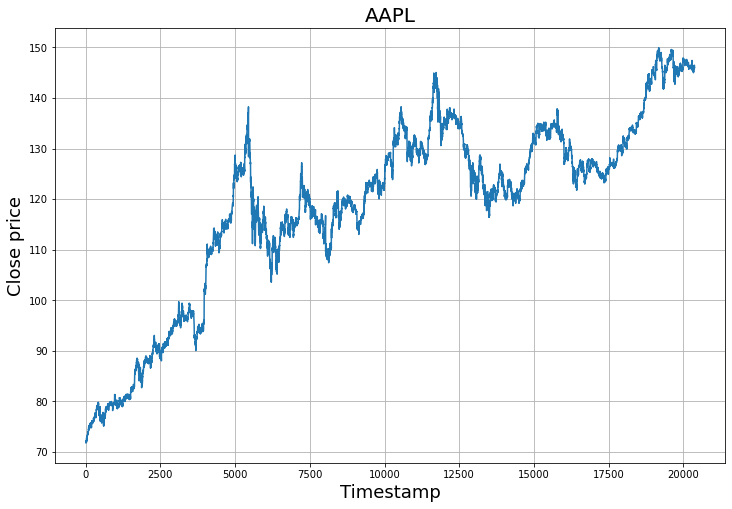

In [35]:
plt.figure(figsize=(12, 8))

plt.plot(range(train_df.shape[0]), train_df["close"])

plt.title("AAPL", fontsize=20)
plt.xlabel("Timestamp", fontsize=18)
plt.ylabel("Close price", fontsize=18)
plt.grid()
plt.show()

## Обучение модели

In [36]:
X_train = train_preprocessed_df.drop(["target"], axis=1).to_numpy()
y_train = train_preprocessed_df["target"].to_numpy()

X_test = test_preprocessed_df.drop(["target"], axis=1).to_numpy()
y_test = test_preprocessed_df["target"].to_numpy()

X_train.shape, X_test.shape

((20272, 104), (4991, 104))

In [37]:
X_train_bounded = X_train[np.abs(y_train) <= threshold]
y_train_bounded = y_train[np.abs(y_train) <= threshold]

Посмотрим на тестовую выборку.

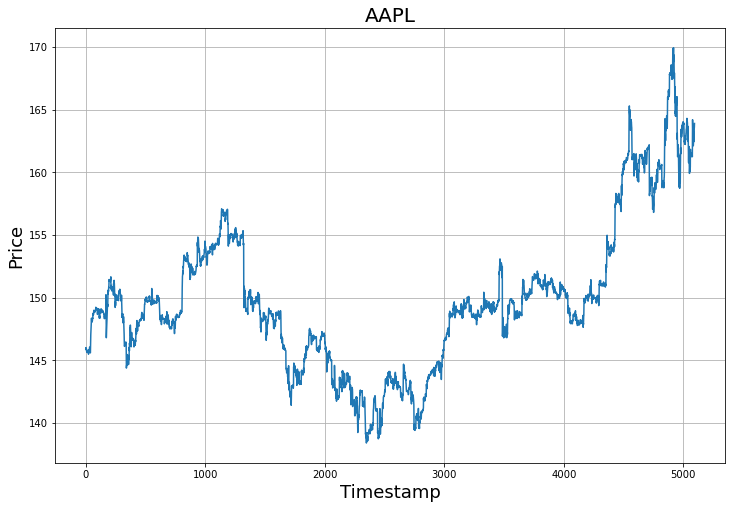

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(test_df)), test_df.close)

plt.title("AAPL", fontsize=20)
plt.xlabel("Timestamp", fontsize=18)
plt.ylabel("Price", fontsize=18)


plt.grid()
plt.show()

### Vanilla LGBMRegressor

In [52]:
def lgbm_objective(trial, X_train, y_train):
    NUM_FOLDS = 4
    lgbm_parameters = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "goss"]),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2),
        "n_estimators": trial.suggest_int("n_estimators", 30, 200),
        "subsample": trial.suggest_float("subsample", 0.2, 1.),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.),
        "reg_lambda": trial.suggest_float("reg_lambda", 0., 0.5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0., 0.5),
    }
    
    tscv = TimeSeriesSplit(n_splits=NUM_FOLDS)
    fold = 1
    loss = 0
    for train_index, test_index in (pbar := tqdm(tscv.split(X_train))):
        X_train_cv = X_train[train_index]
        X_test_cv = X_train[test_index]
        
        y_train_cv = y_train[train_index]
        y_test_cv = y_train[test_index]
        
        lgbm_regressor = LGBMRegressor(random_state=0, **lgbm_parameters)
        lgbm_regressor.fit(X_train_cv, y_train_cv)

        lgbm_predictions = lgbm_regressor.predict(X_test_cv)
        current_mse = mean_squared_error(y_test_cv, lgbm_predictions)
        loss += current_mse
        
        pbar.set_description(f"Fold: {fold}, loss: {current_mse}")
        fold += 1
        
    return loss / NUM_FOLDS

In [53]:
study = optuna.create_study()
study.optimize(lambda trial: lgbm_objective(trial, X_train_bounded, y_train_bounded), n_trials=50)

[I 2022-05-04 08:37:21,293] A new study created in memory with name: no-name-143007db-533e-4e6f-92b8-60ba7875e92f
Fold: 4, loss: 0.0844775340376547: : 4it [00:01,  2.45it/s] 
[I 2022-05-04 08:37:22,947] Trial 0 finished with value: 0.15178908460538232 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': 7, 'learning_rate': 0.004554561625918796, 'n_estimators': 109, 'subsample': 0.35822906227621953, 'colsample_bytree': 0.8049511845463961, 'reg_lambda': 0.04644005131507356, 'reg_alpha': 0.21121119736257093}. Best is trial 0 with value: 0.15178908460538232.
Fold: 4, loss: 0.08843446298810265: : 4it [00:02,  1.93it/s]
[I 2022-05-04 08:37:25,042] Trial 1 finished with value: 0.15404981360051237 and parameters: {'boosting_type': 'goss', 'num_leaves': 19, 'max_depth': 15, 'learning_rate': 0.00914763574197649, 'n_estimators': 145, 'subsample': 0.790653679861897, 'colsample_bytree': 0.8933168416751183, 'reg_lambda': 0.27570232550359963, 'reg_alpha': 0.35929075655451215}. Be

Fold: 4, loss: 0.08390924766880888: : 4it [00:06,  1.71s/it]
[I 2022-05-04 08:38:00,993] Trial 17 finished with value: 0.15118957669538746 and parameters: {'boosting_type': 'goss', 'num_leaves': 80, 'max_depth': 20, 'learning_rate': 0.0021269294533561617, 'n_estimators': 156, 'subsample': 0.45708994972648, 'colsample_bytree': 0.7126215314143132, 'reg_lambda': 0.20382894760409598, 'reg_alpha': 0.43526603481051807}. Best is trial 14 with value: 0.15095166796136206.
Fold: 4, loss: 0.08389269990165239: : 4it [00:01,  2.93it/s]
[I 2022-05-04 08:38:02,423] Trial 18 finished with value: 0.1510571935241336 and parameters: {'boosting_type': 'goss', 'num_leaves': 41, 'max_depth': 14, 'learning_rate': 0.004342499374104575, 'n_estimators': 56, 'subsample': 0.20271964283748076, 'colsample_bytree': 0.3797300940872772, 'reg_lambda': 0.3322075642833525, 'reg_alpha': 0.3193034187440917}. Best is trial 14 with value: 0.15095166796136206.
Fold: 4, loss: 0.08363537221047458: : 4it [00:02,  1.39it/s]
[I 20

Fold: 4, loss: 0.08391138618598759: : 4it [00:04,  1.06s/it]
[I 2022-05-04 08:39:10,530] Trial 34 finished with value: 0.1512160900714152 and parameters: {'boosting_type': 'goss', 'num_leaves': 54, 'max_depth': 19, 'learning_rate': 0.0023569780004272173, 'n_estimators': 127, 'subsample': 0.6314678571954307, 'colsample_bytree': 0.8277805859380131, 'reg_lambda': 0.06888352098460883, 'reg_alpha': 0.09682738434633822}. Best is trial 30 with value: 0.15087736302904742.
Fold: 4, loss: 0.08360911576108934: : 4it [00:06,  1.52s/it]
[I 2022-05-04 08:39:16,653] Trial 35 finished with value: 0.1509015519656998 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'max_depth': 20, 'learning_rate': 0.001061725485027079, 'n_estimators': 142, 'subsample': 0.4381894600613315, 'colsample_bytree': 0.7756188652550526, 'reg_lambda': 0.10965518008342898, 'reg_alpha': 0.0018110014216268094}. Best is trial 30 with value: 0.15087736302904742.
Fold: 4, loss: 0.08917778671573917: : 4it [00:06,  1.56s/it]


Лучшие параметры:

In [62]:
# {'boosting_type': 'goss',
#  'num_leaves': 64,
#  'max_depth': 19,
#  'learning_rate': 0.0008749313759535188,
#  'n_estimators': 122,
#  'subsample': 0.5324777544893021,
#  'colsample_bytree': 0.9052736969225345,
#  'reg_lambda': 0.04672924784096763,
#  'reg_alpha': 0.08375968701008792}

In [54]:
best_lgbm_params = study.best_params
best_lgbm_params

{'boosting_type': 'goss',
 'num_leaves': 64,
 'max_depth': 19,
 'learning_rate': 0.0008749313759535188,
 'n_estimators': 122,
 'subsample': 0.5324777544893021,
 'colsample_bytree': 0.9052736969225345,
 'reg_lambda': 0.04672924784096763,
 'reg_alpha': 0.08375968701008792}

In [55]:
lgbm_regressor = LGBMRegressor(random_state=0, **best_lgbm_params)
lgbm_regressor.fit(X_train_bounded, y_train_bounded)

lgbm_predictions = lgbm_regressor.predict(X_test)
mean_squared_error(y_test, lgbm_predictions)

0.16478014962829426

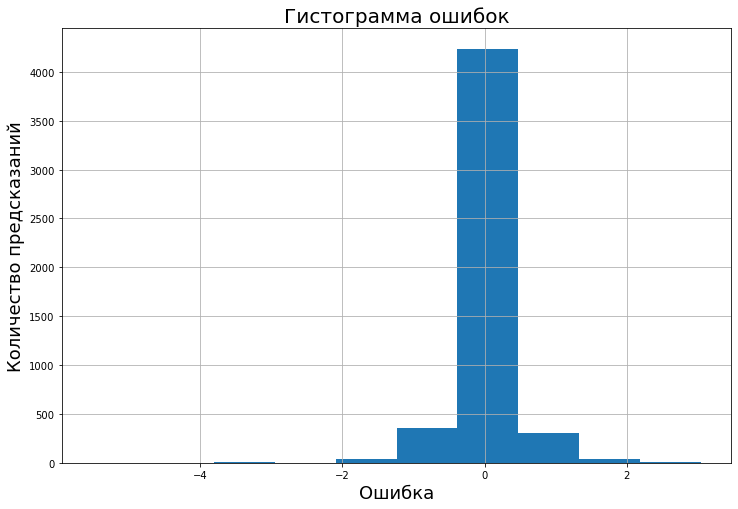

In [56]:
plt.figure(figsize=(12, 8))

plt.hist(y_test - lgbm_predictions)
plt.title("Гистограмма ошибок", fontsize=20)

plt.xlabel("Ошибка", fontsize=18)
plt.ylabel("Количество предсказаний", fontsize=18)

plt.grid()
plt.show()

Также по неравенству Чебышёва отберем 20 процентов самых уверенных предсказаний.

In [57]:
std = lgbm_predictions.std()
order_threshold = np.sqrt(std ** 2 / 0.2)

In [58]:
class_predictions = np.zeros(len(y_test))
class_predictions[lgbm_predictions > order_threshold] = 1
class_predictions[lgbm_predictions < -order_threshold] = 2

true_classes = np.zeros(len(y_test))
true_classes[y_test > order_threshold] = 1
true_classes[y_test < -order_threshold] = 2

confusion_matrix(true_classes, class_predictions)

array([[ 437,    2,    0],
       [2278,   34,   16],
       [2184,   22,   18]], dtype=int64)

### Много LGBMRegressor с разными random_seed

In [59]:
random_states = [42, 154, 342, 1000, 1230, 4432]

predictions = []
for random_state in random_states:
    lgbm_regressor = LGBMRegressor(random_state=random_state, **best_lgbm_params)
    lgbm_regressor.fit(X_train_bounded, y_train_bounded)

    lgbm_predictions = lgbm_regressor.predict(X_test)
    predictions.append(lgbm_predictions)
    
predictions = np.vstack(predictions).mean(axis=0)
mean_squared_error(y_test, predictions)

0.16478557486897466

In [60]:
class_predictions = np.zeros(len(y_test))
class_predictions[predictions > order_threshold] = 1
class_predictions[predictions < -order_threshold] = 2

true_classes = np.zeros(len(y_test))
true_classes[y_test > order_threshold] = 1
true_classes[y_test < -order_threshold] = 2

confusion_matrix(true_classes, class_predictions)

array([[ 437,    2,    0],
       [2282,   29,   17],
       [2188,   18,   18]], dtype=int64)

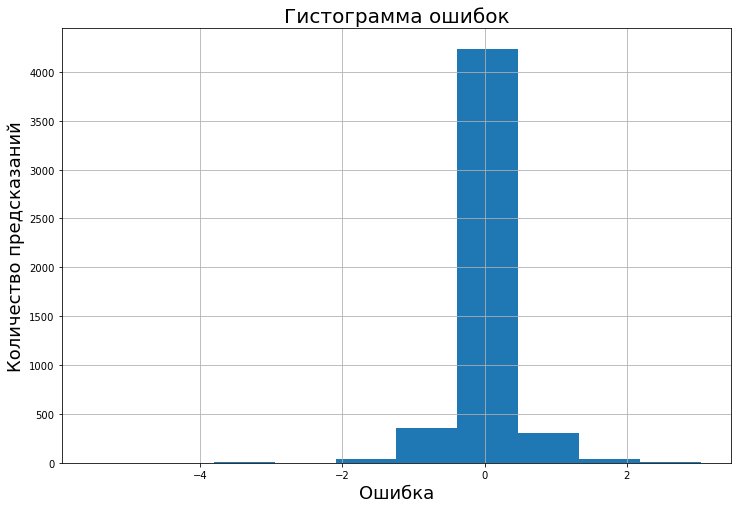

In [61]:
plt.figure(figsize=(12, 8))

plt.hist(y_test - predictions)
plt.title("Гистограмма ошибок", fontsize=20)

plt.xlabel("Ошибка", fontsize=18)
plt.ylabel("Количество предсказаний", fontsize=18)

plt.grid()
plt.show()

### Один LGBMRegressor на всей выборке с выбросами

In [63]:
study = optuna.create_study()
study.optimize(lambda trial: lgbm_objective(trial, X_train, y_train), n_trials=50)

[I 2022-05-04 08:42:00,204] A new study created in memory with name: no-name-983ea761-54ce-43d8-9343-c7de52529563
Fold: 4, loss: 0.11890829593310223: : 4it [00:03,  1.32it/s]
[I 2022-05-04 08:42:03,254] Trial 0 finished with value: 0.22981858882696984 and parameters: {'boosting_type': 'goss', 'num_leaves': 38, 'max_depth': 10, 'learning_rate': 0.008550155862027904, 'n_estimators': 199, 'subsample': 0.2646498141102219, 'colsample_bytree': 0.8358146118107477, 'reg_lambda': 0.10460620014409838, 'reg_alpha': 0.08045853189642033}. Best is trial 0 with value: 0.22981858882696984.
Fold: 4, loss: 0.11065687718211256: : 4it [00:04,  1.13s/it]
[I 2022-05-04 08:42:07,774] Trial 1 finished with value: 0.2206580693122187 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 18, 'learning_rate': 0.00676280319561335, 'n_estimators': 107, 'subsample': 0.7622853249195483, 'colsample_bytree': 0.7582033634585998, 'reg_lambda': 0.3317331710210102, 'reg_alpha': 0.454894696704634}. Best i

Fold: 4, loss: 0.10340435996255051: : 4it [00:01,  3.88it/s]
[I 2022-05-04 08:42:41,780] Trial 17 finished with value: 0.21384850661529078 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 4, 'learning_rate': 0.005194994400337334, 'n_estimators': 63, 'subsample': 0.35714279664211085, 'colsample_bytree': 0.8818838455699596, 'reg_lambda': 0.0016955684712377304, 'reg_alpha': 0.013957075192783025}. Best is trial 14 with value: 0.21240088157080492.
Fold: 4, loss: 0.10302656443497323: : 4it [00:03,  1.04it/s]
[I 2022-05-04 08:42:45,687] Trial 18 finished with value: 0.21441754933113033 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': 16, 'learning_rate': 0.0029559444603755, 'n_estimators': 123, 'subsample': 0.5355071091396347, 'colsample_bytree': 0.6479501701310961, 'reg_lambda': 0.2789873943604652, 'reg_alpha': 0.4961809297864534}. Best is trial 14 with value: 0.21240088157080492.
Fold: 4, loss: 0.10001745276533493: : 4it [00:01,  3.02it/s]
[I 

Fold: 4, loss: 0.10000383438410404: : 4it [00:01,  3.95it/s]
[I 2022-05-04 08:43:10,469] Trial 34 finished with value: 0.21231812070518735 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'max_depth': 4, 'learning_rate': 0.0013007885332093237, 'n_estimators': 66, 'subsample': 0.5782741255415274, 'colsample_bytree': 0.8496007416800194, 'reg_lambda': 0.07873091122571499, 'reg_alpha': 0.4397106048225164}. Best is trial 24 with value: 0.2122936354022502.
Fold: 4, loss: 0.10013513846128713: : 4it [00:00,  4.46it/s]
[I 2022-05-04 08:43:11,427] Trial 35 finished with value: 0.21237990714677474 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'max_depth': 4, 'learning_rate': 0.0020721442317507533, 'n_estimators': 58, 'subsample': 0.6731550992642809, 'colsample_bytree': 0.8284770635178578, 'reg_lambda': 0.08559644509723063, 'reg_alpha': 0.4978773078044219}. Best is trial 24 with value: 0.2122936354022502.
Fold: 4, loss: 0.10091915842484853: : 4it [00:01,  3.10it/s]
[I 2022

Лучшие параметры

In [65]:
# {'boosting_type': 'gbdt',
#  'num_leaves': 27,
#  'max_depth': 4,
#  'learning_rate': 0.0009027072701185022,
#  'n_estimators': 87,
#  'subsample': 0.519308917416814,
#  'colsample_bytree': 0.9221307250623111,
#  'reg_lambda': 0.07111364040014884,
#  'reg_alpha': 0.3486550470634089}

In [66]:
best_lgbm_params = study.best_params
best_lgbm_params

{'boosting_type': 'gbdt',
 'num_leaves': 27,
 'max_depth': 4,
 'learning_rate': 0.0009027072701185022,
 'n_estimators': 87,
 'subsample': 0.519308917416814,
 'colsample_bytree': 0.9221307250623111,
 'reg_lambda': 0.07111364040014884,
 'reg_alpha': 0.3486550470634089}

In [68]:
lgbm_regressor = LGBMRegressor(random_state=0, **best_lgbm_params)
lgbm_regressor.fit(X_train, y_train)

lgbm_predictions = lgbm_regressor.predict(X_test)
mean_squared_error(y_test, lgbm_predictions)

0.16475269104435336

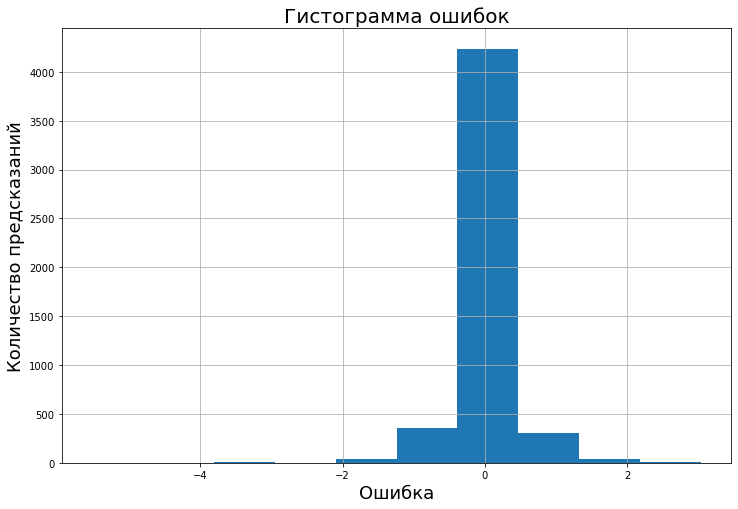

In [69]:
plt.figure(figsize=(12, 8))

plt.hist(y_test - lgbm_predictions)
plt.title("Гистограмма ошибок", fontsize=20)

plt.xlabel("Ошибка", fontsize=18)
plt.ylabel("Количество предсказаний", fontsize=18)

plt.grid()
plt.show()

### Много LGBMRegressor на всей выборке с выбросами

In [70]:
random_states = [42, 154, 342, 1000, 1230, 4432]

predictions = []
for random_state in random_states:
    lgbm_regressor = LGBMRegressor(random_state=random_state, **best_lgbm_params)
    lgbm_regressor.fit(X_train, y_train)

    lgbm_predictions = lgbm_regressor.predict(X_test)
    predictions.append(lgbm_predictions)
    
predictions = np.vstack(predictions).mean(axis=0)
mean_squared_error(y_test, predictions)

0.16474530657645017

In [71]:
class_predictions = np.zeros(len(y_test))
class_predictions[predictions > order_threshold] = 1
class_predictions[predictions < -order_threshold] = 2

true_classes = np.zeros(len(y_test))
true_classes[y_test > order_threshold] = 1
true_classes[y_test < -order_threshold] = 2

confusion_matrix(true_classes, class_predictions)

array([[ 438,    1,    0],
       [2308,   18,    2],
       [2207,   12,    5]], dtype=int64)

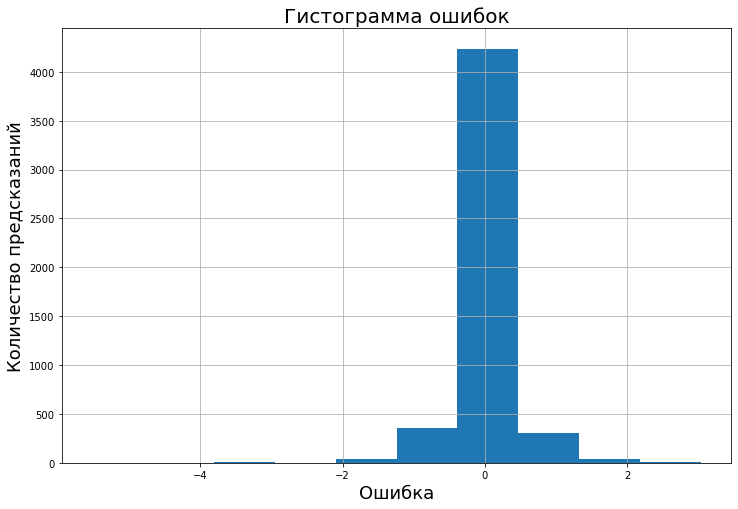

In [72]:
plt.figure(figsize=(12, 8))

plt.hist(y_test - predictions)
plt.title("Гистограмма ошибок", fontsize=20)

plt.xlabel("Ошибка", fontsize=18)
plt.ylabel("Количество предсказаний", fontsize=18)

plt.grid()
plt.show()

# Full dataset train

In [73]:
data = prepare_dataset(DATA_PATH)
data_preprocessed = get_features(data)
data_preprocessed

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [01:11<00:00,  1.00it/s]


,volume,open,close,high,low,date,ticker,target,MFV,14 period ADX.,AO,14 period ATR,Buy.,Sell.,Buy.,Sell.,BB_UPPER,BB_MIDDLE,BB_LOWER,20 period BBWITH,Balance Of Power,20 period CCI,CFI,MFV,Short.,Long.,CMO,Coppock Curve,9 period DEMA,DI+,DI-,LOWER,MIDDLE,UPPER,0,Bull.,Bear.,13 period Force Index,9 period EMA,14 period EMV.,10 period ER,10 period EVSTC,20 period EVWMA.,10 period FISH.,16 period FRAMA.,0,16 period HMA.,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,20 period KAMA.,KC_UPPER,KC_LOWER,KST,signal,MACD,SIGNAL,14 period MFI,Mass Index,BB_UPPER,BB_MIDDLE,BB_LOWER,MOM,MSD,pivot,s1,s2,s3,s4,r1,r2,r3,r4,PPO,SIGNAL,HISTO,14 period PZO,14 period QSTICK.,ROC,14 period RSI,41 period SMA,9 period SMM,SMMA,20 period SQZMI,9 period SSMA,10 period STC,14 period STOCH %K,3 period STOCH %D.,14 period stochastic RSI.,9 period TEMA,TP,TR,18 period TRIMA,20 period TRIX,TSI,signal,0,8 period VAMA,VBM,VIm,VIp,VWAP.,VZO,14 Williams %R,9 period WMA.,WOBV,WT1.,WT2.,26 period ZLEMA
0,13828.0,72.0625,72.000,72.0625,71.7875,2020-05-04 07:51:00,AAPL,-0.0800,7.542545e+03,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,-0.227273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.062500,-0.212500,NaN,72.000000,NaN,NaN,NaN,0.000000,0.000000,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,72.4373,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,72.000000,False,72.000000,NaN,NaN,NaN,NaN,72.000000,71.950000,0.2750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,6856.0,72.0000,71.975,72.0000,71.9050,2020-05-04 08:06:00,AAPL,0.0250,1.079012e+04,NaN,NaN,NaN,0.335554,0.386173,0.651166,0.677741,NaN,NaN,NaN,NaN,-0.263158,66.666667,NaN,NaN,NaN,NaN,-100.000000,NaN,71.979938,NaN,NaN,NaN,NaN,NaN,NaN,0.013462,-0.081538,-171.400000,71.986111,NaN,NaN,NaN,0.000000,0.000000,71.975000,NaN,NaN,NaN,NaN,NaN,NaN,72.5036,NaN,NaN,NaN,NaN,NaN,-0.000561,-0.000312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.950000,71.837500,71.675000,71.562500,71.450,72.112500,72.225000,72.387500,72.550,-0.000779,-0.000433,-0.000346,-53.562791,NaN,NaN,0.000000,NaN,NaN,71.987349,False,71.986765,NaN,NaN,NaN,NaN,71.977195,71.960000,0.0950,NaN,-0.005025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.953315,-36.390143,NaN,NaN,-1.714000e+02,121.212121,NaN,NaN
2,7012.0,72.0100,71.920,72.0150,71.9200,2020-05-04 08:21:00,AAPL,-0.0450,3.778124e+03,NaN,NaN,NaN,0.000000,1.189878,0.412062,0.865794,NaN,NaN,NaN,NaN,-0.947368,-36.363636,NaN,NaN,NaN,NaN,-100.000000,NaN,71.939383,NaN,NaN,NaN,NaN,NaN,NaN,0.054134,-0.040866,-286.770769,71.959016,NaN,NaN,NaN,0.000000,0.000000,71.920000,NaN,NaN,NaN,NaN,NaN,NaN,72.7200,NaN,NaN,NaN,NaN,NaN,-0.002420,-0.001176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.960000,71.920000,71.865000,71.825000,71.785,72.015000,72.055000,72.110000,72.165,-0.003363,-0.001634,-0.001729,-71.291815,NaN,NaN,0.000000,NaN,NaN,71.964356,False,71.961843,NaN,NaN,NaN,NaN,71.929820,71.951667,0.0950,NaN,-0.007436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.952897,-55.500165,NaN,NaN,-5.570600e+02,24.387567,NaN,NaN
3,1064.0,71.9725,72.000,72.0000,71.9725,2020-05-04 08:36:00,AAPL,-0.0900,4.842124e+03,NaN,NaN,NaN,0.057147,0.000000,0.309603,0.615853,NaN,NaN,NaN,NaN,1.000000,133.333333,NaN,NaN,NaN,NaN,6.844741,NaN,71.969098,NaN,NaN,NaN,NaN,NaN,NaN,0.026986,-0.000514,-143.285354,71.972900,NaN,NaN,NaN,0.000000,0.000000,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,72.6400,NaN,NaN,NaN,NaN,NaN,-0.000318,-0.000885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.951667,71.888333,71.856667,71.793333,71.730,71.983333,72.046667,72.078333,72.110,-0.000442,-0.001230,0.000788,-18.869191,NaN,NaN,52.415176,NaN,NaN,71.973592,False,71.973128,NaN,NaN,NaN,NaN,71.973242,71.990833,0.0800,NaN,-0.004696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.954301,-47.729611,NaN,NaN,-4.719400e+02,77.235189,NaN,NaN
4,20052.0,72.0625,71.875,72.0625,71.8750,2020-05-04 08:51:00,AAPL,-0.1075,-1.520988e+04,NaN,NaN,NaN,0.000000,5.006174,0.234713,1.677834,NaN,NaN,NaN,NaN,-1.000000,-98.086124,N

In [74]:
data_preprocessed.drop(drop_columns, axis=1, inplace=True)

In [75]:
data_preprocessed

,volume,open,close,high,low,target,14 period ADX.,AO,14 period ATR,Buy.,Sell.,Buy.,Sell.,BB_UPPER,BB_MIDDLE,BB_LOWER,20 period BBWITH,20 period CCI,CFI,Short.,Long.,CMO,Coppock Curve,9 period DEMA,DI+,DI-,LOWER,MIDDLE,UPPER,0,Bull.,Bear.,13 period Force Index,9 period EMA,14 period EMV.,10 period ER,10 period EVSTC,20 period EVWMA.,10 period FISH.,16 period FRAMA.,0,16 period HMA.,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,20 period KAMA.,KC_UPPER,KC_LOWER,KST,signal,MACD,SIGNAL,14 period MFI,Mass Index,BB_UPPER,BB_MIDDLE,BB_LOWER,MOM,MSD,pivot,s1,s2,s3,s4,r1,r2,r3,r4,PPO,SIGNAL,HISTO,14 period PZO,ROC,14 period RSI,41 period SMA,9 period SMM,SMMA,20 period SQZMI,9 period SSMA,10 period STC,14 period STOCH %K,3 period STOCH %D.,14 period stochastic RSI.,9 period TEMA,TP,TR,18 period TRIMA,20 period TRIX,TSI,signal,0,8 period VAMA,VBM,VIm,VIp,VWAP.,VZO,14 Williams %R,9 period WMA.,WOBV,WT1.,WT2.,26 period ZLEMA
0,13828.0,72.0625,72.000,72.0625,71.7875,-0.0800,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.062500,-0.212500,NaN,72.000000,NaN,NaN,NaN,0.000000,0.000000,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,72.4373,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,72.000000,False,72.000000,NaN,NaN,NaN,NaN,72.000000,71.950000,0.2750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,6856.0,72.0000,71.975,72.0000,71.9050,0.0250,NaN,NaN,NaN,0.335554,0.386173,0.651166,0.677741,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,NaN,-100.000000,NaN,71.979938,NaN,NaN,NaN,NaN,NaN,NaN,0.013462,-0.081538,-171.400000,71.986111,NaN,NaN,NaN,0.000000,0.000000,71.975000,NaN,NaN,NaN,NaN,NaN,NaN,72.5036,NaN,NaN,NaN,NaN,NaN,-0.000561,-0.000312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.950000,71.837500,71.675000,71.562500,71.450,72.112500,72.225000,72.387500,72.550,-0.000779,-0.000433,-0.000346,-53.562791,NaN,0.000000,NaN,NaN,71.987349,False,71.986765,NaN,NaN,NaN,NaN,71.977195,71.960000,0.0950,NaN,-0.005025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.953315,-36.390143,NaN,NaN,-1.714000e+02,121.212121,NaN,NaN
2,7012.0,72.0100,71.920,72.0150,71.9200,-0.0450,NaN,NaN,NaN,0.000000,1.189878,0.412062,0.865794,NaN,NaN,NaN,NaN,-36.363636,NaN,NaN,NaN,-100.000000,NaN,71.939383,NaN,NaN,NaN,NaN,NaN,NaN,0.054134,-0.040866,-286.770769,71.959016,NaN,NaN,NaN,0.000000,0.000000,71.920000,NaN,NaN,NaN,NaN,NaN,NaN,72.7200,NaN,NaN,NaN,NaN,NaN,-0.002420,-0.001176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.960000,71.920000,71.865000,71.825000,71.785,72.015000,72.055000,72.110000,72.165,-0.003363,-0.001634,-0.001729,-71.291815,NaN,0.000000,NaN,NaN,71.964356,False,71.961843,NaN,NaN,NaN,NaN,71.929820,71.951667,0.0950,NaN,-0.007436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.952897,-55.500165,NaN,NaN,-5.570600e+02,24.387567,NaN,NaN
3,1064.0,71.9725,72.000,72.0000,71.9725,-0.0900,NaN,NaN,NaN,0.057147,0.000000,0.309603,0.615853,NaN,NaN,NaN,NaN,133.333333,NaN,NaN,NaN,6.844741,NaN,71.969098,NaN,NaN,NaN,NaN,NaN,NaN,0.026986,-0.000514,-143.285354,71.972900,NaN,NaN,NaN,0.000000,0.000000,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,72.6400,NaN,NaN,NaN,NaN,NaN,-0.000318,-0.000885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.951667,71.888333,71.856667,71.793333,71.730,71.983333,72.046667,72.078333,72.110,-0.000442,-0.001230,0.000788,-18.869191,NaN,52.415176,NaN,NaN,71.973592,False,71.973128,NaN,NaN,NaN,NaN,71.973242,71.990833,0.0800,NaN,-0.004696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.954301,-47.729611,NaN,NaN,-4.719400e+02,77.235189,NaN,NaN
4,20052.0,72.0625,71.875,72.0625,71.8750,-0.1075,NaN,NaN,NaN,0.000000,5.006174,0.234713,1.677834,NaN,NaN,NaN,NaN,-98.086124,NaN,NaN,NaN,-44.567414,NaN,71.920646,NaN,NaN,71.7875,NaN,NaN,NaN,0.115545,-0.071955,-876.844290,71.943777,NaN,NaN,NaN,0.000000,0.000000,71.875000,NaN,NaN,NaN,NaN,NaN,NaN,72.7550,NaN,NaN,NaN,NaN,NaN,-0.004143,-0.001854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.990833,71.981667,71.963333,71.954167,71.945,72.009167,72.018333,72.036667,72.05

In [76]:
X = data_preprocessed.drop(["target"], axis=1).to_numpy()
y = data_preprocessed["target"].to_numpy()

In [77]:
lgbm_regressor = LGBMRegressor(random_state=0, **best_lgbm_params)
lgbm_regressor.fit(X, y)

LGBMRegressor(colsample_bytree=0.9221307250623111,
              learning_rate=0.0009027072701185022, max_depth=4, n_estimators=87,
              num_leaves=27, random_state=0, reg_alpha=0.3486550470634089,
              reg_lambda=0.07111364040014884, subsample=0.519308917416814)

In [78]:
with open(MODEL_PATH, "wb") as output_file:
    pickle.dump(lgbm_regressor, output_file)

In [79]:
lgbm_regressor.booster_.save_model(MODEL_PATH)